In [72]:
import sys
get_ipython().system('{sys.executable} -m pip install --quiet numpy pandas matplotlib seaborn scikit-learn')

599319.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Color Moments

In [84]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from PIL import Image


### Setup

Crop automatico per isolare il cervello - Task1-2

In [85]:
def crop_to_brain(img):
    """Ritaglia l'area informativa (cervello) da un'immagine."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    return img  # fallback

In [86]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "color_moments_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "color_moments_part2.npz")



### Task 1-2

Estrazione Color Moments su griglia - Task 1-2

In [87]:
def extract_color_moments(img_path):
    """Estrae Color Moments su una griglia 10x10 da un'immagine."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {img_path}")
        return None

    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))  # Griglia uniforme

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk): sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])
    return features

 Estrazione feature da più cartelle e salvataggio in .npz

In [88]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_color_moments(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

### Task 3

Ricerca immagini simili (Euclidea) - Task 3

In [92]:
def find_k_similar(base_folder, img_path, k):
    """Trova le k immagini più simili in base alla distanza euclidea."""
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} immagini simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match = cv2.imread(os.path.join(base_folder, lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={distances[idx]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

Ricerca immagini simili (Mahalanobis) - Task 3

In [90]:
def find_k_similar_mahalanobis(base_folder, img_path, k):
    """Trova le k immagini più simili usando distanza di Mahalanobis, escludendo la query."""
    # Estrai le feature dalla query
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)

    # Calcola matrice di covarianza delle feature
    cov = np.cov(feat_matrix_part1.T)

    # Inversione con fallback alla pseudoinversa
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Uso pseudoinversa per matrice non invertibile.")
        cov_inv = np.linalg.pinv(cov)

    # Calcola distanza di Mahalanobis tra la query e tutte le immagini
    distances = np.array([
        mahalanobis(query_feature, f, cov_inv) for f in feat_matrix_part1
    ])

    # Opzionale: escludi la query stessa (distanza 0)
    # === Escludi la query basandoti sul path ===
    query_filename = os.path.basename(img_path)
    query_label = os.path.basename(os.path.dirname(img_path))

    for i in range(len(flname_part1)):
        if flname_part1[i] == query_filename and lbls_part1[i] == query_label:
            distances[i] = np.inf
            break

    # Seleziona i top-k indici a distanza minima
    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    # Output testuale
    print(f"\nTop {k} immagini simili (Mahalanobis): {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(
            f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {top_k_scores[rank]:.2f}")

    # Visualizza le immagini
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match_path = os.path.join(
            base_folder, lbls_part1[idx], flname_part1[idx])
        img_match = cv2.imread(img_match_path)
        axs[i + 1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i + 1}\nD={top_k_scores[i]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

Esecuzione: Estrazione e salvataggio

In [91]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "color_moments_part1.npz")
process_and_save_features("Part2", subfolders, "color_moments_part2.npz")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in color_moments_part1.npz
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in color_moments_part2.npz


Esecuzione

In [ ]:
base_folder = "Part1"
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(base_folder, query_img, k=5)
find_k_similar_mahalanobis(base_folder, query_img, k=7)

### Task 4

Task 4:

	1.	Accetti come input:
	    •	un’immagine di query (da “Part2”)
	    •	una scelta dell’utente sul tipo di feature space
	    •	un valore intero k <= 2.
	2.	Calcoli le features dell’immagine di query secondo il feature space selezionato.
	3.	Calcoli la distanza tra la query e tutte le immagini del dataset (es. Euclidea o Mahalanobis).
	4.	Raggruppi le distanze per label e selezioni le k classi (etichette) più simili in media.
	5.	Stampi/ritorni una classifica delle k etichette più probabili con il rispettivo punteggio (es. distanza  media o somma inversa delle distanze).

Un feature space è lo spazio vettoriale dove ogni immagine è rappresentata come un vettore di caratteristiche (feature vector).

Il selected feature space indica quale tipo di caratteristiche estrai per rappresentare l’immagine.

In [11]:

def predict_top_k_labels(query_img_path,k):
    assert k <= 2, "k deve essere <= 2"

    # Estrazione delle feature dalla query (basata su Color Moments)
    query_feature = extract_color_moments(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return
    
    
    query_feature = np.array(query_feature).reshape(1, -1)
    # Calcolo della distanza euclidea tra la query e tutte le immagini nel dataset
    distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()

    # Creazione di un DataFrame per semplificare le operazioni successive
    df = pd.DataFrame({
        'filename': flname_part1,  # nome immagine
        'label': lbls_part1,        # etichetta (classe)
        'distance': distances   # distanza dalla query
    })

    # Calcola la distanza media per classe
    avg_dist_per_label = df.groupby('label')['distance'].mean().sort_values()

    # Prendi le k classi più simili (minore distanza = maggiore similarità)
    top_k_labels = avg_dist_per_label.head(k)

    print(f"\nClassifica delle {k} etichette più probabili per la query:")
    for i, (label, score) in enumerate(top_k_labels.items(), 1):
        print(f"{i}. {label} | Score (distanza media): {score:.4f}")

In [12]:
def predict_top_k_labels_by_prototypes(query_img_path, k=2):
    """
    Predice le k etichette più probabili per una query image confrontandola
    con i prototipi (centroidi) di ciascuna classe nello spazio delle feature.

    Parametri:
    - query_img_path: percorso dell'immagine di query (parte 2)
    - k: numero massimo di etichette da restituire (k <= 2)

    Strategia:
    - Calcola la media (prototipo) delle feature per ciascuna classe
    - Confronta la query con ogni prototipo usando distanza euclidea
    - Restituisce le k etichette con distanza minore (cioè più simili)
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_color_moments(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # Costruzione DataFrame per calcolo dei prototipi per classe
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1

    # Calcolo dei centroidi (prototipi) per ciascuna classe
    class_prototypes = df_features.groupby('label').mean()

    # Rimozione della colonna "label" dal prototipo (è diventato indice)
    prototype_vectors = class_prototypes.values
    prototype_labels = class_prototypes.index

    # Calcolo della distanza della query da ciascun prototipo
    distances = euclidean_distances(prototype_vectors, query_feature).flatten()

    # Ordinamento per distanza crescente
    sorted_indices = np.argsort(distances)
    top_k = [(prototype_labels[i], distances[i]) for i in sorted_indices[:k]]

    # Output
    print(f"\n Classifica delle {k} etichette più vicine ai prototipi:")
    for i, (label, dist) in enumerate(top_k, 1):
        print(f"{i}. {label} | Distanza dal prototipo: {dist:.4f}")

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"
predict_top_k_labels_by_prototypes(query_img, k=2)

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"
predict_top_k_labels(query_img,k=2)

In [15]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_color_moments(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = euclidean_distances(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

### Task 5

Task 5

feature model è il file dei dati delle feature che già estratto. Una rappresentazione di tutte le immagini del dataset in un certo feature space, salvata come matrice (feature_matrix), dove ogni riga è un’immagine (matrice n x d, dove n è il numero di immagini, e d il numero di feature).

Dato:

	•	un feature model (es. color_moments.npz)
	•	un valore k
	•	una tecnica di riduzione dimensionale (SVD, LDA, k-means)

Esegui:

	•	Riduzione delle dimensioni nel feature space selezionato
	•	Estrai le top-k componenti latenti
	•	Per ogni componente, produci e salva: (immagine, peso) ordinati per importanza
	•	Salva tutto in un file con nome chiaro (es. latent_semantics_svd_color_moments_k3.txt)

Cosa rappresenta K ? numero di componenti latenti che vuoi estrarre.

SVD --> K è ilnumero di componenti principali - Riduce le dimensioni mantenendo variazione.

LDA --> k è il numero di direzioni discriminanti - Riduce le dimensioni separando meglio le classi.

k-means --> k è il numero di cluster - Divide le immagini in k gruppi simili (senza usare etichette)




In [17]:

def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    print(f"[DEBUG] Shape X_svd (dati trasformati): {X_transformed.shape}")
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()

def task5_latent_semantics(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature usando SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi associati alle immagini.
    """

    technique = technique.lower()
    method = ""
    X_transformed = None
    components = None

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

    # Creazione output
    os.makedirs("task5_output", exist_ok=True)
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join("task5_output", f"latent_semantics_{method}_{base_name}_k{k}.txt")

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
                sorted_idx = np.argsort(-np.abs(weights))
            else:  # KMeans: distanza dal centroide, più piccola = più vicino
                weights = -X_transformed[:, i]
                sorted_idx = np.argsort(weights)

            for idx in sorted_idx:
                image_id = flname_part1[idx]
                f.write(f"{image_id} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

In [ ]:
n_components=min(feat_matrix_part1.shape)

task5_latent_semantics("color_moments.npz", technique="svd", k=5)
task5_latent_semantics("color_moments.npz", technique="svd", k=n_components)
task5_latent_semantics("color_moments.npz", technique="lda", k=2)
task5_latent_semantics("color_moments.npz", technique="kmeans", k=7)

### Task 6

Obiettivo del Task 6

Trasformazione in uno spazio latente ortonormale: Utilizzando una tecnica di riduzione dimensionale, trasformiamo l’insieme delle feature originali in un nuovo spazio le cui componenti sono ortonormali.

Concentrazione del potere discriminante: Le componenti vengono ordinate in base alla varianza spiegata (cioè, la potenza discriminante). In questo modo, le prime componenti (quelle con varianza più elevata) contengono la maggior parte dell’informazione utile, mentre le componenti successive sono meno significative.

Dimensionalità intrinseca: Se il numero di componenti latenti (m) ottenute è uguale al numero di feature di partenza, la trasformazione preserva esattamente tutte le distanze ed angoli (cioè, la trasformazione è invertibile e non viene persa informazione). Se invece la dimensionalità intrinseca è minore di m, allora potrai scegliere di mantenere solo quelle componenti più significative. In questo caso, le distanze e gli angoli nel database trasformato saranno approssimati, introducendo un errore proporzionale alla quantità di informazione “persa” trascurando le componenti meno significative.

explained = pca.explained_variance_ratio_

Questa riga:
	Ottiene un array di float dove ciascun valore rappresenta la percentuale di varianza spiegata da ciascuna componente principale della PCA.

	È ordinato dalla componente più importante a quella meno importante.

esempio: explained = [0.40, 0.30, 0.20, 0.07, 0.03]

Significa:
    La prima componente spiega il 40% della varianza

	La seconda il 30%, ecc.



cumulative = np.cumsum(explained)

Calcola la somma cumulativa dell’array explained, cioè la varianza totale spiegata fino a ciascuna componente.

es:cumulative = [0.40, 0.70, 0.90, 0.97, 1.00]

Significa:
	•	Le prime 2 componenti spiegano il 70%
	•	Le prime 3 il 90%
	•	Le prime 4 il 97%, ecc.


intrinsic_dim = np.argmax(cumulative >= threshold) + 1

Questa riga:
	•	Trova il primo indice in cui la varianza cumulativa raggiunge o supera una soglia (threshold), ad esempio 0.95 (95%).
	•	np.argmax(...) restituisce il primo True nella condizione cumulative >= threshold.
	•	Si aggiunge +1 perché gli indici Python partono da 0, ma il numero di componenti parte da 1.

studio del k migliore

In [19]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [20]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


In [ ]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

### Task 7

Implementare un programma che:

1) per ogni etichetta unica l, calcoli la corrispondente k semantica latente (a scelta)
associata alle immagini della parte 1 

2) per le immagini della parte 2, preveda le etichette più probabili utilizzando le distanze/similitudini calcolate
in base alla semantica latente specifica dell'etichetta.
Il sistema deve inoltre fornire i valori di precisione, richiamo e punteggio F1 per etichetta, nonché
un valore di accuratezza complessiva.


1. Estrazione della semantica latente per ogni classe
Funzione: compute_latent_semantics_per_class(X, y, k)

Input:
- X: Matrice delle caratteristiche delle immagini della Parte 1.
- y: Vettore delle etichette corrispondenti.
- k: Numero di componenti latenti da estrarre tramite SVD.

Output:
- class_models: Contiene scaler, modello SVD e vettori latenti per ciascuna classe.
- class_means: Contiene il vettore medio (centroide latente) per ciascuna classe.


2 Funzione: predict_label(X_test, class_models, class_means)

Input:
- X_test: Matrice delle immagini da classificare.
- class_models: Modelli latenti per ciascuna classe.
- class_means: Centroidi dei vettori latenti per ciascuna classe.

Output:
- y_pred: Lista delle etichette previste per ciascuna immagine.




Funzioni: evaluate(y_true, y_pred), evaluate_predictions(true_labels, predicted_labels)

Metriche calcolate:
- Precisione per classe
- Recall per classe
- F1 score per classe
- Accuratezza complessiva


Ogni classe ha uno spazio semantico proprio, dove le immagini sono rappresentate in modo compatto.
L'immagine da classificare è proiettata in ogni spazio latente e assegnata alla classe più simile in base alla distanza dal centroide.


In [24]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [99]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.55, R=0.41, F1=0.47
Class brain_menin: P=0.46, R=0.59, F1=0.52
Class brain_tumor: P=0.30, R=0.29, F1=0.30

Overall Accuracy: 0.43

              precision    recall  f1-score   support

brain_glioma       0.55      0.41      0.47      1002
 brain_menin       0.46      0.59      0.52      1002
 brain_tumor       0.30      0.29      0.30      1002

    accuracy                           0.43      3006
   macro avg       0.44      0.43      0.43      3006
weighted avg       0.44      0.43      0.43      3006



In [114]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from PIL import Image

def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni con PCA, quindi applica DBSCAN
    e restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA -> Riduzione a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più popolosi" che vogliamo restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1) 
    ordinati in base alla dimensione (numero di occorrenze) decrescente.
    Se DBSCAN ha trovato meno di c cluster, restituisce tutti quelli disponibili.
    """
    # Conteggio delle occorrenze per ogni etichetta di cluster
    label_counts = Counter(cluster_labels)
    # Rimuovo il rumore (-1) se presente
    label_counts.pop(-1, None)
    
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i c cluster più frequenti
    most_common = label_counts.most_common(c)  # es. [(label1, count1), (label2, count2), ...]
    top = [int(lbl) for lbl, _ in most_common]
    
    # Se DBSCAN ha trovato meno di c cluster, most_common contiene già tutti
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle tue feature originali (senza aver fatto PCA).
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi pari ai cluster "significativi" (col più grandi).
    metric: la distanza da usare per MDS (default 'euclidean').
    Mostra un grafico 2D (scatter) con i punti appartenenti ai top_clusters colorati diversamente,
    tutti gli altri (cluster minori o -1) in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le features originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Calcolo la matrice di distanze (facoltativo) e poi MDS → Y (N×2)
    #    Qui usiamo MDS “direttamente” su features_scaled, che di default assume euclidea.
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    Y = mds.fit_transform(features_scaled)

    # 3) Plotto i punti
    import matplotlib
    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16‐25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)


            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()



[INFO] Elaboro label: brain_glioma
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1  2]
[INFO] Top 3 cluster (per dimensione): [1, 2, 0]
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


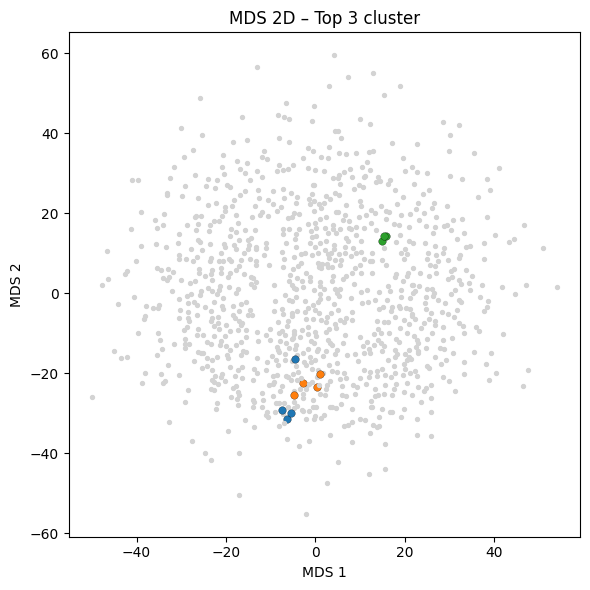

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …
[INFO] Cluster 1: 4 immagini trovate


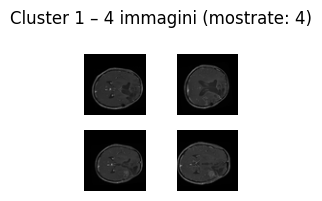

[INFO] Cluster 2: 4 immagini trovate


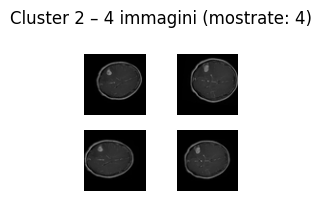

[INFO] Cluster 0: 3 immagini trovate


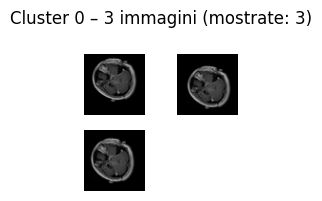


[INFO] Elaboro label: brain_menin
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1]
[WARN] DBSCAN ha trovato solo 2 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [1, 0]
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


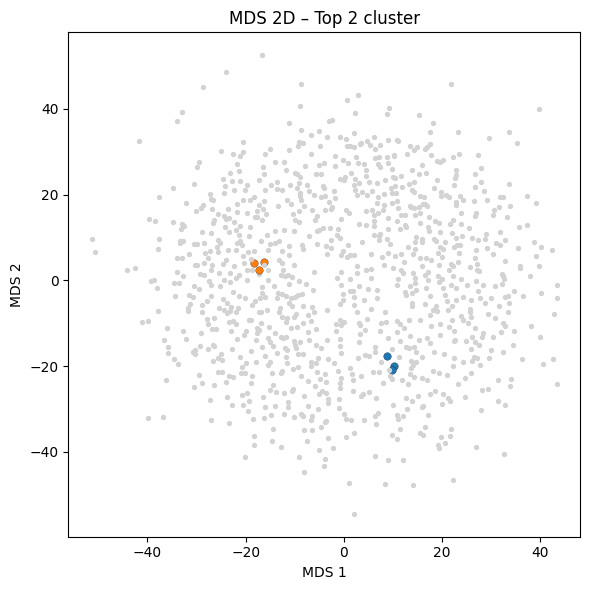

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …
[INFO] Cluster 1: 3 immagini trovate


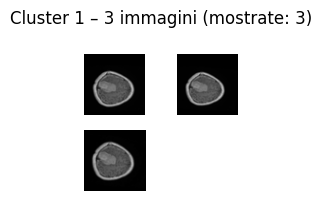

[INFO] Cluster 0: 3 immagini trovate


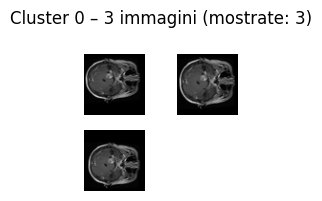


[INFO] Elaboro label: brain_tumor
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0]
[WARN] DBSCAN ha trovato solo 1 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [0]
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


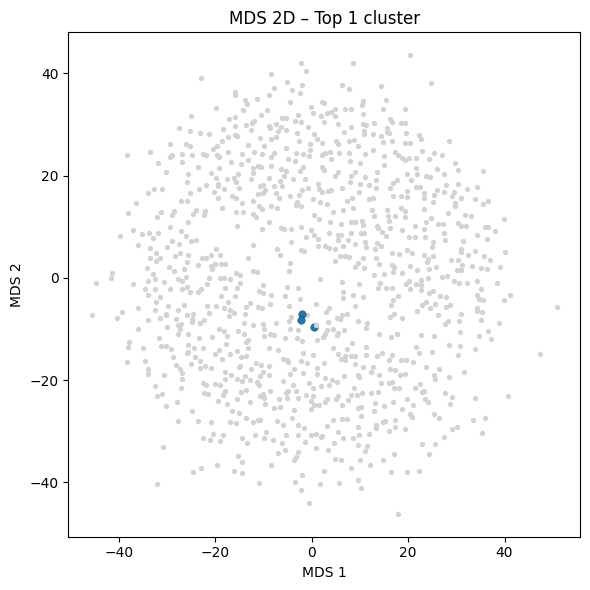

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …
[INFO] Cluster 0: 3 immagini trovate


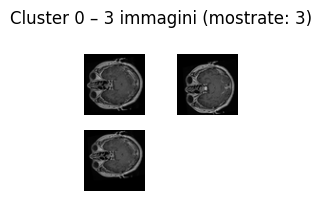


[FINITO] Task 8 completato per tutte le label di Parte1.


In [117]:
# ================================
# BLOCCHETTO PER TASK 8 (RIUSO FUNZIONI)
# ================================

# 3) PARAMETRI (modificabili a piacere)
eps = 2.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label

# 4) Creare una cartella di output (facoltativo)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 3) Costruisco l’elenco dei full path per tutte le immagini
base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
images_full = [ os.path.join(base_folder, lbl, fname)
                for fname, lbl in zip(flname_part1, lbls_part1) ]

# 5) SCORRO OGNI LABEL DI Parte1 E APPLICO DBSCAN+PCA
unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

for lbl in unique_labels:
    print(f"\n==============================")
    print(f"[INFO] Elaboro label: {lbl}")
    print(f"==============================")

    # 5.1) Estraggo le righe di feat_matrix_part1 / flname_part1 corrispondenti
    mask_lbl = (lbls_part1 == lbl)
    features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
    images_label   = np.array(images_full)[mask_lbl]

    # 5.2) Chiamo la tua funzione che fa PCA + DBSCAN
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

    # 5.3) Trovo i c cluster più grandi
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 5.4) Creo sotto-cartella di output per questa label
    out_dir_lbl = os.path.join(output_base, f"label_{lbl}")
    os.makedirs(out_dir_lbl, exist_ok=True)

    # 5.5) MDS‐2D + scatter plot del clustering
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    # (ATTENZIONE: plot_mds_clusters in genere “fa plt.show()” a video.
    #  Se vuoi salvare l’immagine invece di far vedere a notebook, 
    #  devi modificare leggermente quella funzione per usare plt.savefig())
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se invece vuoi **salvare** l’immagine in PNG anziché fare “show()”:
    #    plt.savefig(os.path.join(out_dir_lbl, f"{lbl}_MDS_clusters.png"))
    #    plt.close()

    # 5.6) Creo le miniature di ogni cluster “significativo”
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,      # array di stringhe di percorsi
        cluster_labels,    # array di int di lunghezza n_i
        top_clusters,      # la lista dei c indici di cluster
        thumb_size=(64, 64)
    )
    # Anche qui, di default quella funzione fa plt.show() per ogni cluster.
    # Se vuoi salvare le figure in file, modifica show_cluster_thumbnails in
    # modo che setti un outpath e faccia plt.savefig().

print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")
